In [ ]:
!pip install opencv-python scikit-image numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2

def ace_color_constancy(image, threshold=0.1):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    l, a, b = cv2.split(lab)

    mean_l = np.mean(l)
    l = l - mean_l
    l = np.clip(l, -threshold * 255, threshold * 255)
    l = l + mean_l
    l = l.astype(a.dtype)
    l = cv2.normalize(l, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    adjusted_lab = cv2.merge([l, a, b])
    return cv2.cvtColor(adjusted_lab, cv2.COLOR_Lab2BGR)

def compute_difference(original, processed):
    return cv2.absdiff(original, processed)

In [ ]:
import os
import cv2
from tqdm import tqdm

def preprocess_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for subdir in ['Fake', 'Real']:
        input_subdir = os.path.join(input_dir, subdir)
        output_subdir = os.path.join(output_dir, subdir)
        os.makedirs(output_subdir, exist_ok=True)

        for filename in tqdm(os.listdir(input_subdir), desc=f"Processing {subdir}"):
            filepath = os.path.join(input_subdir, filename)
            image = cv2.imread(filepath)

            # Apply ACE and calculate difference
            processed = ace_color_constancy(image)
            difference = compute_difference(image, processed)

            # Save original, processed, and difference images
            cv2.imwrite(os.path.join(output_subdir, f"{filename.split('.')[0]}_original.jpg"), image)
            cv2.imwrite(os.path.join(output_subdir, f"{filename.split('.')[0]}_difference.jpg"), difference)

# Preprocess the dataset
# input_dir = "/content/drive/MyDrive/Deep fake detection using lighting inconsistancy/images/train"
# output_dir = "/content/drive/MyDrive/Deep fake detection using lighting inconsistancy/preprocessed_images/train"
# preprocess_images(input_dir, output_dir)


In [ ]:
import os

real_count = len(os.listdir('/content/drive/MyDrive/RP/DeepFakeDatasetResearch/images/train/Real'))
fake_count = len(os.listdir('/content/drive/MyDrive/RP/DeepFakeDatasetResearch/images/train/Fake'))

print(f"Real: {real_count}, Fake: {fake_count}")

Real: 2106, Fake: 2100


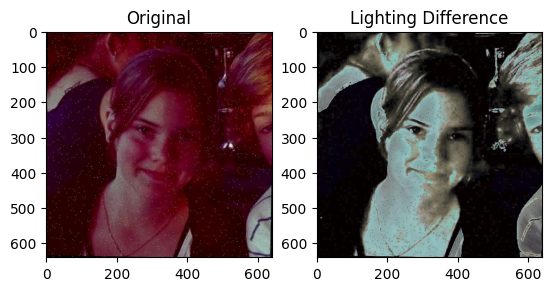

In [ ]:
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/RP/Lighting output/Real/real_0_jpg_original.jpg'
processed_path = '/content/drive/MyDrive/RP/Lighting output/Real/real_0_jpg_difference.jpg'

original = cv2.imread(image_path)
processed = cv2.imread(processed_path)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
plt.title("Lighting Difference")

plt.show()


In [ ]:
from torch.utils.data import Dataset
import torch
from torchvision.transforms import ToTensor
import os

class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        for label, subdir in enumerate(['Fake', 'Real']):
            subdir_path = os.path.join(root_dir, subdir)
            for filename in os.listdir(subdir_path):
                if '_original' in filename:
                    self.data.append((filename, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename, label = self.data[idx]
        original_path = os.path.join(self.root_dir, 'Fake' if label == 0 else 'Real', filename)
        difference_path = original_path.replace('_original', '_difference')

        original = cv2.imread(original_path)
        difference = cv2.imread(difference_path)

        if self.transform:
            original = self.transform(original)
            difference = self.transform(difference)

        combined = torch.cat((original, difference), dim=0)
        return combined, label

train_dataset = DeepfakeDataset('/content/drive/MyDrive/RP/Lighting output', transform=ToTensor())


In [ ]:
import torch
import torchvision.models as models
from torch import nn

class LightingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc = nn.Linear(1000, 2)

    def forward(self, x):
        features = self.backbone(x)
        return self.fc(features)

model = LightingModel()


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = LightingModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decay every 5 epochs

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, LR: {current_lr}")

Using device: cuda


Epoch 1/50, Loss: 0.7000653156164017, LR: 0.0001


Epoch 2/50, Loss: 0.5004147436385128, LR: 0.0001


Epoch 3/50, Loss: 0.3907680909826674, LR: 0.0001


Epoch 4/50, Loss: 0.2672703046542169, LR: 0.0001


Epoch 5/50, Loss: 0.26499627287690103, LR: 5e-05


Epoch 6/50, Loss: 0.15351723791735078, LR: 5e-05


Epoch 7/50, Loss: 0.08773554152486956, LR: 5e-05


Epoch 8/50, Loss: 0.08302673910987902, LR: 5e-05


Epoch 9/50, Loss: 0.06803550223478604, LR: 5e-05


Epoch 10/50, Loss: 0.07664700768807299, LR: 2.5e-05


Epoch 11/50, Loss: 0.022764139166859175, LR: 2.5e-05


Epoch 12/50, Loss: 0.05539913106423972, LR: 2.5e-05


Epoch 13/50, Loss: 0.026789347716575405, LR: 2.5e-05


Epoch 14/50, Loss: 0.01291722425858924, LR: 2.5e-05


Epoch 15/50, Loss: 0.019816337704055928, LR: 1.25e-05


Epoch 16/50, Loss: 0.00842914045671767, LR: 1.25e-05


Epoch 17/50, Loss: 0.01846106041950241, LR: 1.25e-05


Epoch 18/50, Loss: 0.012633055189388126, LR: 1.25e-05


Epoch 19/50, Loss: 0.006768262213840485, LR: 1.25e-05


Epoch 20/50, Loss: 0.00874675032375969, LR: 6.25e-06


Epoch 21/50, Loss: 0.0035653206921944566, LR: 6.25e-06


Epoch 22/50, Loss: 0.0025289492111462346, LR: 6.25e-06


Epoch 23/50, Loss: 0.0034359314816211654, LR: 6.25e-06


Epoch 24/50, Loss: 0.0052772086352878105, LR: 6.25e-06


Epoch 25/50, Loss: 0.001760888965954812, LR: 3.125e-06


Epoch 26/50, Loss: 0.004676935254627262, LR: 3.125e-06


Epoch 27/50, Loss: 0.002665189997760432, LR: 3.125e-06


Epoch 28/50, Loss: 0.0026827986499711187, LR: 3.125e-06


Epoch 29/50, Loss: 0.001746009837202936, LR: 3.125e-06


Epoch 30/50, Loss: 0.0007598894614075521, LR: 1.5625e-06


Epoch 31/50, Loss: 0.0008562263244223025, LR: 1.5625e-06


Epoch 32/50, Loss: 0.0021669368404879856, LR: 1.5625e-06


Epoch 33/50, Loss: 0.0022007492467537304, LR: 1.5625e-06


Epoch 34/50, Loss: 0.0026206033441217805, LR: 1.5625e-06


Epoch 35/50, Loss: 0.002825031650621151, LR: 7.8125e-07


Epoch 36/50, Loss: 0.004675547749002362, LR: 7.8125e-07


Epoch 37/50, Loss: 0.0013246178127908272, LR: 7.8125e-07


Epoch 38/50, Loss: 0.0008104824242784823, LR: 7.8125e-07


Epoch 39/50, Loss: 0.0015141955488967471, LR: 7.8125e-07


Epoch 40/50, Loss: 0.0008063567964055354, LR: 3.90625e-07


Epoch 41/50, Loss: 0.0029698776471708366, LR: 3.90625e-07


Epoch 42/50, Loss: 0.003133484736157367, LR: 3.90625e-07


Epoch 43/50, Loss: 0.0015905148205619794, LR: 3.90625e-07


Epoch 44/50, Loss: 0.004733095562135697, LR: 3.90625e-07


Epoch 45/50, Loss: 0.0020490758522245496, LR: 1.953125e-07


Epoch 46/50, Loss: 0.001347202035534875, LR: 1.953125e-07


Epoch 47/50, Loss: 0.0007353640948644304, LR: 1.953125e-07


Epoch 48/50, Loss: 0.001970653685165499, LR: 1.953125e-07


Epoch 49/50, Loss: 0.0020711526823850527, LR: 1.953125e-07


Epoch 50/50, Loss: 0.0016897153004668492, LR: 9.765625e-08


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/RP/Lighting model/lighting_model.pth')

Testing

In [ ]:
# preprocess_images('/content/drive/MyDrive/RP/DeepFakeDatasetResearch/images/test', '/content/drive/MyDrive/RP/Lighting test/preprocessed_images/test')

Processing Real: 100%|██████████| 97/97 [00:02<00:00, 35.51it/s]


In [ ]:
test_dataset = DeepfakeDataset('/content/drive/MyDrive/RP/Lighting test/preprocessed_images/test', transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# model.load_state_dict(torch.load('deepfake_model.pth'))  # Load trained model
# model.eval()  # Set model to evaluation mode

In [ ]:
import torch

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU

        outputs = model(inputs)  # Now both inputs & model weights are on the same device
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 78.00%


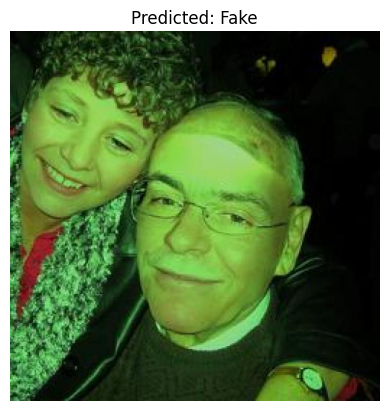

In [ ]:
import torch
import matplotlib.pyplot as plt

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_single(image_path):
    image = cv2.imread(image_path)
    processed = ace_color_constancy(image)
    difference = compute_difference(image, processed)

    transform = ToTensor()
    image_tensor = transform(image)
    difference_tensor = transform(difference)

    input_tensor = torch.cat((image_tensor, difference_tensor), dim=0).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to(device)  # Move input tensor to the same device as the model

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    label = "Fake" if predicted.item() == 0 else "Real"

    # Display result
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {label}")
    plt.axis("off")
    plt.show()

# Example usage
predict_single('/content/drive/MyDrive/RP/DeepFakeDatasetResearch/images/test/Fake/fake_39_jpg.rf.bd072ab23d40d5b7d6e762af730be3c7.jpg')